In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_epochs = 100
batch_size = 32
split = 0.4 # best at 0.7/0.6 . Big difference for 0.3,0.4

# Baseline reading with only stock prices

In [3]:
df = pd.read_csv('./datasets/AAPL.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-02-01,19.462856,19.512857,18.882856,19.107143,12.740701,252686000
1,2008-02-04,19.172857,19.414286,18.774286,18.807142,12.540661,224808500
2,2008-02-05,18.632856,19.142857,18.414286,18.480000,12.322518,285260500
3,2008-02-06,18.690001,18.845715,17.395714,17.428572,11.621424,393318100
4,2008-02-07,17.138571,17.825714,16.752857,17.320000,11.549030,520832900


## We are only going to consider the opening price

In [5]:
df = df.drop(df.columns[2:],axis=1)
df.head()

,Date,Open
0,2008-02-01,19.462856
1,2008-02-04,19.172857
2,2008-02-05,18.632856
3,2008-02-06,18.690001
4,2008-02-07,17.138571


### Graph of the entire dataset

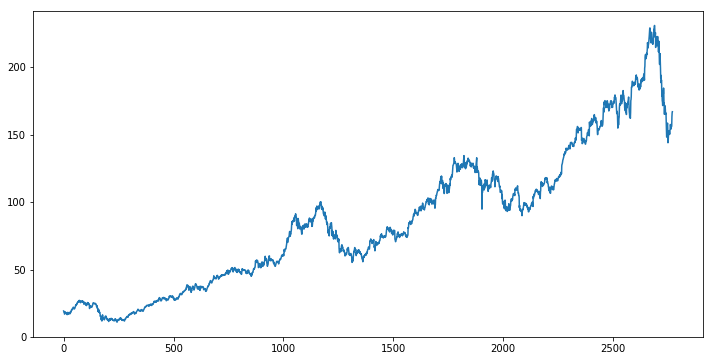

In [6]:
df['Open'].plot(figsize=(12,6))

In [7]:
training = split
total = df.shape[0]
train_index = int(total*training)

training_set = df[:train_index]

## Feature scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(pd.DataFrame(training_set['Open']))

## Take time window to be 60 days

In [9]:
X_train = []
y_train = []
for i in range(60, train_index):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


### Create the LSTM model

In [11]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1048/1048 [==============================] - 6s 6ms/step - loss: 0.0235
Epoch 2/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0034
Epoch 3/100
1048/1048 [==============================] - 4s 3ms/step - loss: 0.0034
Epoch 4/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0030
Epoch 5/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0029
Epoch 6/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0024
Epoch 7/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0029
Epoch 8/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0032
Epoch 9/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0026
Epoch 10/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0026
Epoch 11/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0023
Epoch 12/100
1048/1048 [==

1048/1048 [==============================] - 4s 3ms/step - loss: 9.7069e-04
Epoch 94/100
1048/1048 [==============================] - 4s 3ms/step - loss: 0.0012
Epoch 95/100
1048/1048 [==============================] - 4s 3ms/step - loss: 9.4330e-04
Epoch 96/100
1048/1048 [==============================] - 4s 3ms/step - loss: 0.0010
Epoch 97/100
1048/1048 [==============================] - 4s 3ms/step - loss: 9.9466e-04
Epoch 98/100
1048/1048 [==============================] - 4s 3ms/step - loss: 8.9992e-04
Epoch 99/100
1048/1048 [==============================] - 4s 3ms/step - loss: 0.0012
Epoch 100/100
1048/1048 [==============================] - 4s 3ms/step - loss: 0.0011


In [13]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Open
1108,2012-06-25,82.471428
1109,2012-06-26,81.618568
1110,2012-06-27,82.142860
1111,2012-06-28,81.667145
1112,2012-06-29,82.571426


In [14]:
real_stock_price = pd.DataFrame(testing_set['Open']).reset_index(drop=True)

In [15]:
test_set=testing_set['Open']
test_set=pd.DataFrame(test_set)

In [16]:
inputs = df['Open'][len(df) - len(testing_set) - 60:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(60, 60+(total-train_index)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [17]:
predicted_stock_price=pd.DataFrame(predicted_stock_price)
predicted_stock_price_old = predicted_stock_price

## Plotting predicted vs actual

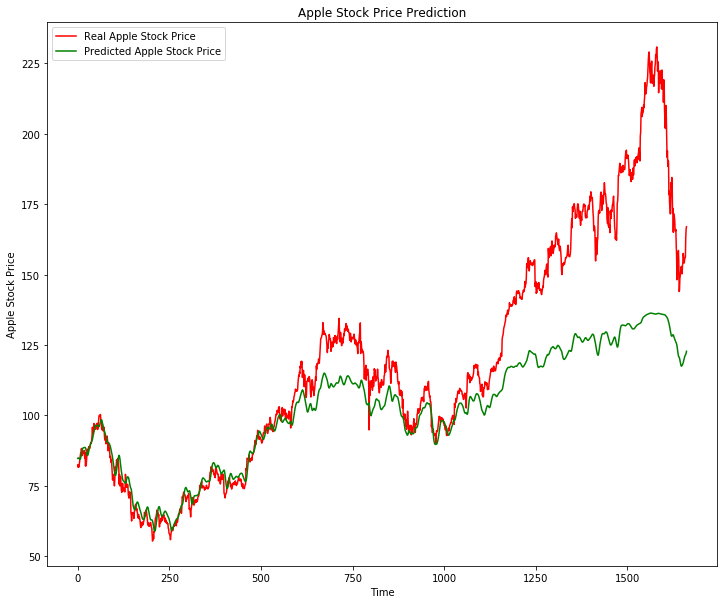

In [18]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_stock_price, color = 'red', label = 'Real Apple Stock Price')
plt.plot(predicted_stock_price_old, color = 'green', label = 'Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

# Using sentiment from news articles and twitter

In [19]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import mean_squared_error

## Get the cleaned datasets

In [20]:
final_news = pd.read_csv('./datasets/news_clean.csv')
final_tweets = pd.read_csv('./datasets/tweets_clean.csv')


## Load the stock prices + logistic regression sentiment score

In [21]:
df_lstm = pd.read_csv('./datasets/AAPL_regression.csv')

## Add the sentiment values as new columns

In [22]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

dataset = pd.DataFrame(df['Open'])
dataset['Avg'] = df_lstm['Avg']

dataset_scaled = sc.fit_transform(dataset)

dataset_scaled

array([[0.03701003, 0.82142857],
       [0.03568848, 0.14285714],
       [0.03322765, 0.92857143],
       ...,
       [0.69226012, 0.60714286],
       [0.70529339, 0.89795918],
       [0.70916693, 0.92857143]])

## Split into training and testing

In [23]:
training = split
total = dataset_scaled.shape[0]
train_index = int(total*training)


## Taking time window as 60 days

In [24]:
X = []
y = []
for i in range(60, total):
    X.append(dataset_scaled[i-60:i])
    y.append(dataset_scaled[i])
X, y = np.array(X), np.array(y)


In [25]:
X_train = X[:train_index]
y_train = y[:train_index]
X_test = X[train_index:]
# X_test.shape

## LSTM

In [26]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 2)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 2))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [27]:
model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size)

Epoch 1/100
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0634
Epoch 2/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0229
Epoch 3/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0189
Epoch 4/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0183
Epoch 5/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0185
Epoch 6/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0171
Epoch 7/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0170
Epoch 8/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0165
Epoch 9/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0171
Epoch 10/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0161
Epoch 11/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0174
Epoch 12/100
1108/1108 [==============================] - 4s 3ms/step - lo

1108/1108 [==============================] - 4s 3ms/step - loss: 0.0136
Epoch 98/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0136
Epoch 99/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0136
Epoch 100/100
1108/1108 [==============================] - 4s 3ms/step - loss: 0.0134


In [28]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Open
1108,2012-06-25,82.471428
1109,2012-06-26,81.618568
1110,2012-06-27,82.142860
1111,2012-06-28,81.667145
1112,2012-06-29,82.571426


In [29]:
real_stock_price = pd.DataFrame(testing_set['Open']).reset_index(drop=True)

In [30]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [31]:
predicted=pd.DataFrame(predicted_stock_price)
real_price = real_stock_price[60:].reset_index(drop=True)
predicted_old = predicted_stock_price_old[60:].reset_index(drop=True)

## Plotting predicted with sentimet vs predicted without sentiment vs actual

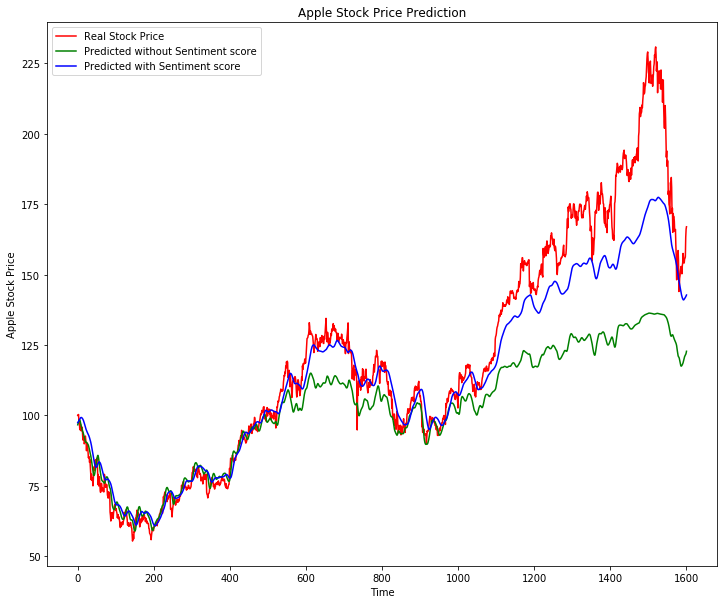

In [32]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_old, color = 'green', label = 'Predicted without Sentiment score')
plt.plot(predicted[0], color = 'blue', label = 'Predicted with Sentiment score')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [33]:
print("MSE of prediction with sentiment score: ", mean_squared_error(real_price, predicted[0]))
print("MSE of prediction without sentiment score: ", mean_squared_error(real_price, predicted_old))    

MSE of prediction with sentiment score:  185.4433103179256
MSE of prediction without sentiment score:  791.2428374815804


# Observation

We can see that the Mean Squared error for predicted stock prices are better when we use stock prices along with sentiment scores, which proves the 